In [2]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns
from torchsummary import summary
import argparse


# experiment design
- pick a dataset
- pick a scaling factor (sf)
- train with 25% of dataset and test on the rest
- train until no improvement is seen for 10 epochs
- best F1 for validation set is the score of the experiment

In [5]:
torch.cuda.set_device(1)
datasets = ["PTBXL","ChapmanShaoxing","CPSC2018",]
norm_type = "minmax"
max_len = 8000
sf = 0.5
scale_type = "nearest"
architecture = "inception"
DATASET_ID = "CPSC2018"
transforms = ["sc","n"]
batch_tfms = []

processing_type = '-'.join([x for x in transforms])

if "sc" in transforms:
    batch_tfms.append(tfs.Scale(scale_factor=sf,mode=scale_type))

if "n" in transforms:
    if norm_type == "minmax":
        batch_tfms.append(tfs.NormMinMax())
    if norm_type == "maxdiv":
        batch_tfms.append(tfs.NormMaxDiv())
    if norm_type == "zscore":
        batch_tfms.append(tfs.NormZScore())
    if norm_type == "median":
        batch_tfms.append(tfs.NormMedian())
    if norm_type == "deci_scale":
        batch_tfms.append(tfs.NormDecimalScaling())
        
if "bp" in transforms:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in transforms:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(transforms)==0:
    processing_type = "raw"
print("transforms:",[x.name for x in batch_tfms])
print(processing_type)

transforms: ['Scale', 'NormMinMax']
sc-n


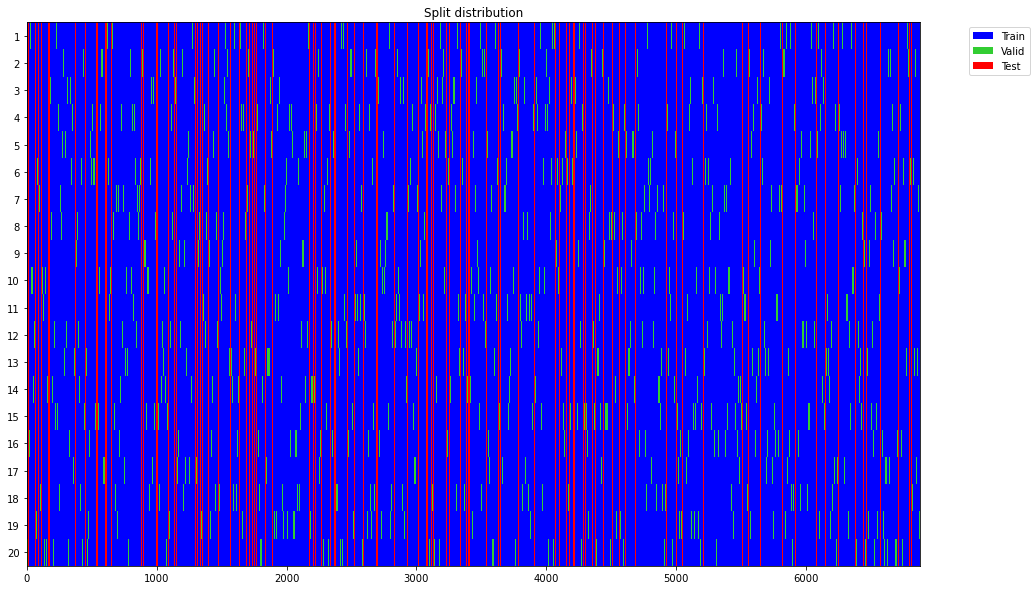

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, '1st degree av block': 722, 'premature atrial contraction': 616}


In [40]:
DATASET_NAME = "WFDB_%s_signitured"%DATASET_ID
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)
y = y[y.columns[y.sum()>0.05*len(y)] ]

cv_splits = get_splits(y.to_numpy(), n_splits = 20, valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))
tfms  = [None, TSMultiLabelClassification()]



In [ ]:
for cv_num in range(20):
#     cv_num = cv_num + 0
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=cv_splits[cv_num]) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi]
    if architecture == "inception":
        model = InceptionTimePlus(dls.vars, dls.c, dls.len,)
    elif architecture == "minirocket":
        model = MiniRocketPlus(dls.vars, dls.c,dls.len)
    # try : loss_func = BCEWithLogitsLossFlat(pos_weight=dls.train.cws.sqrt())
    
    learn = Learner(dls, model, metrics=metrics,
#                     opt_func = wrap_optimizer(torch.optim.Adam,weight_decay=6.614e-07),
                    cbs=[fastai.callback.all.SaveModelCallback(
                        monitor="F1_multi",fname="%s_%s_%s_%s_%s"%(architecture,DATASET_ID,processing_type,sf,cv_num)),
                        fastai.callback.all.EarlyStoppingCallback(monitor='F1_multi', min_delta=0.005, patience=50)
                        ],
                    model_dir="models/scaling/")

    learn.fit_one_cycle(400, lr_max=0.01,)
    # now test it on test set
    learn.load("%s_%s_%s_%s_%s"%(architecture,DATASET_ID,processing_type,sf,cv_num))
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)

    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    y_pred = (valid_preds>0)
    y_test = valid_targets
    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    df = pd.DataFrame(report).reset_index()
    df.to_csv("models/scaling/csvs/%s_%s_%s_%s_%s.csv"%(architecture,DATASET_ID,processing_type,sf,cv_num),index=False)
    df

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.385104,0.458478,0.810599,0.607877,0.344466,0.321071,0.894682,0.332268,00:14
1,0.331827,0.370803,0.886175,0.657129,0.751156,0.333166,0.981093,0.460390,00:14
2,0.305722,0.336204,0.869124,0.673585,0.582604,0.396884,0.950287,0.471796,00:14
3,0.286487,0.317021,0.890323,0.699105,0.709652,0.428465,0.969746,0.533815,00:13
4,0.265730,0.271684,0.900461,0.696882,0.822659,0.408880,0.984884,0.546185,00:13
5,0.245688,0.322719,0.864977,0.688095,0.549390,0.437759,0.938431,0.487209,00:14
6,0.221917,0.205118,0.919816,0.747419,0.909694,0.503474,0.991364,0.646426,00:13
7,0.205641,0.225797,0.912903,0.727709,0.885865,0.465681,0.989738,0.610351,00:12
8,0.194392,0.223290,0.915207,0.756388,0.829622,0.531671,0.981104,0.647764,00:14
9,0.185440,0.213502,0.923963,0.782467,0.852456,0.582219,0.982715,0.691633,00:14


Better model found at epoch 0 with F1_multi value: 0.332267701625824.
Better model found at epoch 1 with F1_multi value: 0.46039021015167236.
Better model found at epoch 2 with F1_multi value: 0.47179630398750305.
Better model found at epoch 3 with F1_multi value: 0.5338147282600403.
Better model found at epoch 4 with F1_multi value: 0.5461850762367249.
Better model found at epoch 6 with F1_multi value: 0.6464260816574097.
Better model found at epoch 8 with F1_multi value: 0.6477639675140381.
Better model found at epoch 9 with F1_multi value: 0.6916332840919495.
Better model found at epoch 11 with F1_multi value: 0.7156020998954773.
Better model found at epoch 12 with F1_multi value: 0.723828136920929.
Better model found at epoch 13 with F1_multi value: 0.737199068069458.
Better model found at epoch 16 with F1_multi value: 0.7670852541923523.
Better model found at epoch 19 with F1_multi value: 0.7781198024749756.
Better model found at epoch 57 with F1_multi value: 0.7783735990524292.
B

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.379996,0.392515,0.874654,0.581615,0.909297,0.165935,0.997295,0.280184,00:13
1,0.324335,0.326585,0.880645,0.628995,0.769671,0.272047,0.985943,0.401959,00:13
2,0.295275,0.307928,0.889862,0.660164,0.805481,0.334386,0.985942,0.472532,00:13
3,0.273157,0.339701,0.882489,0.630090,0.798151,0.272078,0.988103,0.405807,00:14
4,0.251021,0.265926,0.901383,0.736898,0.745188,0.503528,0.970269,0.600525,00:13
5,0.227945,0.317315,0.876498,0.667808,0.640652,0.371841,0.963776,0.470320,00:13
6,0.209491,0.319346,0.882028,0.725308,0.624238,0.503049,0.947566,0.556632,00:14
7,0.198067,0.223845,0.919816,0.773504,0.838501,0.565937,0.981070,0.675733,00:13
8,0.186886,0.202226,0.924424,0.765627,0.911604,0.540449,0.990806,0.678234,00:13
9,0.179373,0.186752,0.931797,0.789588,0.921318,0.587829,0.991348,0.717384,00:13


Better model found at epoch 0 with F1_multi value: 0.2801838517189026.
Better model found at epoch 1 with F1_multi value: 0.4019588828086853.
Better model found at epoch 2 with F1_multi value: 0.4725323021411896.
Better model found at epoch 4 with F1_multi value: 0.6005251407623291.
Better model found at epoch 7 with F1_multi value: 0.6757331490516663.
Better model found at epoch 8 with F1_multi value: 0.6782343983650208.
Better model found at epoch 9 with F1_multi value: 0.7173840403556824.
Better model found at epoch 11 with F1_multi value: 0.7454208135604858.
Better model found at epoch 12 with F1_multi value: 0.7614765167236328.
Better model found at epoch 23 with F1_multi value: 0.7740618586540222.
Better model found at epoch 60 with F1_multi value: 0.7792419791221619.
No improvement since epoch 60: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.383592,0.378042,0.866359,0.546066,0.844978,0.094827,0.997305,0.169346,00:15
1,0.327691,0.750087,0.804147,0.583576,0.304844,0.272818,0.894335,0.287861,00:13
2,0.299643,0.533767,0.832258,0.618786,0.401551,0.317888,0.919684,0.354333,00:14
3,0.275025,0.413421,0.853456,0.629538,0.492082,0.314062,0.945014,0.383406,00:13
4,0.253122,0.284151,0.888940,0.633172,0.881423,0.272818,0.993527,0.415384,00:13
5,0.230418,0.281859,0.892166,0.704000,0.707444,0.438739,0.969261,0.541449,00:14
6,0.207012,0.296492,0.879263,0.676647,0.643078,0.391056,0.962237,0.485429,00:13
7,0.197020,0.281667,0.891705,0.725943,0.673511,0.492322,0.959565,0.568692,00:14
8,0.187078,0.249359,0.902304,0.732339,0.749693,0.492726,0.971952,0.594562,00:13
9,0.177930,0.221769,0.918433,0.768115,0.825642,0.556169,0.980060,0.663642,00:14


Better model found at epoch 0 with F1_multi value: 0.16934561729431152.
Better model found at epoch 1 with F1_multi value: 0.2878609299659729.
Better model found at epoch 2 with F1_multi value: 0.3543325662612915.
Better model found at epoch 3 with F1_multi value: 0.3834058344364166.
Better model found at epoch 4 with F1_multi value: 0.4153840243816376.
Better model found at epoch 5 with F1_multi value: 0.5414494872093201.
Better model found at epoch 7 with F1_multi value: 0.5686923265457153.
Better model found at epoch 8 with F1_multi value: 0.5945616960525513.
Better model found at epoch 9 with F1_multi value: 0.6636416912078857.
Better model found at epoch 12 with F1_multi value: 0.6816306114196777.
Better model found at epoch 14 with F1_multi value: 0.7255229353904724.
Better model found at epoch 55 with F1_multi value: 0.7298657298088074.
No improvement since epoch 14: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.371770,0.891152,0.810599,0.586221,0.309991,0.272871,0.899571,0.290196,00:15
1,0.323384,0.579885,0.816129,0.590968,0.327057,0.276431,0.905505,0.298836,00:13
2,0.295904,0.384583,0.857604,0.644817,0.496441,0.347633,0.942001,0.408618,00:13
3,0.271114,0.343594,0.888018,0.623225,0.862149,0.253423,0.993026,0.390405,00:13
4,0.250268,0.275477,0.899078,0.705178,0.748757,0.434536,0.975820,0.548822,00:14
5,0.229513,0.450328,0.851152,0.674953,0.473054,0.428858,0.921049,0.449818,00:14
6,0.205086,0.226319,0.917051,0.760616,0.809347,0.542170,0.979062,0.647629,00:13
7,0.190645,0.276027,0.893548,0.741884,0.654448,0.529946,0.953821,0.585086,00:12
8,0.181853,0.229158,0.922581,0.785493,0.809430,0.594072,0.976914,0.684142,00:14
9,0.173731,0.196746,0.928571,0.796773,0.839742,0.612885,0.980661,0.708041,00:13


Better model found at epoch 0 with F1_multi value: 0.29019638895988464.
Better model found at epoch 1 with F1_multi value: 0.298835813999176.
Better model found at epoch 2 with F1_multi value: 0.4086184501647949.
Better model found at epoch 4 with F1_multi value: 0.5488220453262329.
Better model found at epoch 6 with F1_multi value: 0.6476288437843323.
Better model found at epoch 8 with F1_multi value: 0.6841423511505127.
Better model found at epoch 9 with F1_multi value: 0.708041250705719.
Better model found at epoch 13 with F1_multi value: 0.7163525223731995.
Better model found at epoch 27 with F1_multi value: 0.7221972942352295.
Better model found at epoch 30 with F1_multi value: 0.7348399758338928.
Better model found at epoch 50 with F1_multi value: 0.7511500120162964.
Better model found at epoch 51 with F1_multi value: 0.7702005505561829.
Better model found at epoch 93 with F1_multi value: 0.8075212836265564.
No improvement since epoch 93: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.384764,0.425999,0.847465,0.572517,0.419496,0.188509,0.956526,0.259238,00:14
1,0.337721,0.433041,0.829032,0.578434,0.341290,0.228282,0.928585,0.272423,00:14
2,0.311004,0.308771,0.878802,0.647567,0.646790,0.324656,0.970478,0.431031,00:14
3,0.287104,0.612775,0.816590,0.577420,0.313065,0.243437,0.911403,0.273689,00:14
4,0.262897,0.517571,0.817972,0.591753,0.332922,0.275850,0.907657,0.301329,00:14
5,0.241019,0.255662,0.901843,0.686213,0.829576,0.385317,0.987109,0.524920,00:13
6,0.217358,0.235777,0.908756,0.727003,0.801039,0.473327,0.980680,0.594896,00:13
7,0.202432,0.233563,0.921198,0.756089,0.865653,0.525614,0.986563,0.653394,00:14
8,0.189641,0.212914,0.922120,0.765816,0.847189,0.547740,0.983892,0.664344,00:13
9,0.180838,0.204648,0.921659,0.771158,0.834623,0.561123,0.981193,0.670096,00:14


Better model found at epoch 0 with F1_multi value: 0.2592379152774811.
Better model found at epoch 1 with F1_multi value: 0.27242258191108704.
Better model found at epoch 2 with F1_multi value: 0.431031197309494.
Better model found at epoch 5 with F1_multi value: 0.5249204039573669.
Better model found at epoch 6 with F1_multi value: 0.5948964953422546.
Better model found at epoch 7 with F1_multi value: 0.6533937454223633.
Better model found at epoch 8 with F1_multi value: 0.6643441319465637.
Better model found at epoch 9 with F1_multi value: 0.6700955033302307.
Better model found at epoch 10 with F1_multi value: 0.7121126055717468.
Better model found at epoch 11 with F1_multi value: 0.7185413241386414.
Better model found at epoch 27 with F1_multi value: 0.7232465147972107.
Better model found at epoch 45 with F1_multi value: 0.7365654110908508.
Better model found at epoch 47 with F1_multi value: 0.7572047710418701.
Better model found at epoch 64 with F1_multi value: 0.7707803845405579.
